In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu, sobel
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from skimage import io, exposure, color
from skimage import measure, morphology
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
import cv2
import re

In [17]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def extract_channels(image: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Extract green and red channels from the squeezed image (shape: [Z, C, H, W]).""" 
    return image[0], image[1]

def calculate_surface_area(labeled_image: np.ndarray) -> float:
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)

def remove_small_objects_only(binary_image, min_size=100):
    labeled_image = measure.label(binary_image)

    # Remove objects smaller than min_size
    filtered_image = morphology.remove_small_objects(labeled_image, min_size=min_size)

    # Convert back to binary mask
    return filtered_image > 0

def analysis(red: np.ndarray, green:np.ndarray, path:str) -> pd.DataFrame:
    data = []
    df_cell_summary = pd.DataFrame()

    contrast_adjusted_red_normalized = (red - red.min()) / (red.max() - red.min())
    threshold_value_mitochondria = np.mean(contrast_adjusted_red_normalized) + (np.std(contrast_adjusted_red_normalized) * 2.25) #1.75 works well
    mitochondria_thresholded = contrast_adjusted_red_normalized > threshold_value_mitochondria
    mitochondria_thresholded = remove_small_objects_only(mitochondria_thresholded, min_size=10)


    if (re.search(r'LLOMe', path)):
        constrast_adjusted_green_normalized = (green - green.min()) / (green.max() - green.min())
        threshold_value_green = np.mean(constrast_adjusted_green_normalized) + (np.std(constrast_adjusted_green_normalized) * 4) #1.75 works well
        green_thresholded = constrast_adjusted_green_normalized > threshold_value_green
        green_thresholded = remove_small_objects_only(green_thresholded, min_size=10)
    else: 
        constrast_adjusted_green_normalized = (green - green.min()) / (green.max() - green.min())
        threshold_value_green = np.mean(constrast_adjusted_green_normalized) + (np.std(constrast_adjusted_green_normalized) * 1) #1.75 works well
        green_thresholded = constrast_adjusted_green_normalized > threshold_value_green
        green_thresholded = remove_small_objects_only(green_thresholded, min_size=35)

    red_surface_area = calculate_surface_area(label(mitochondria_thresholded))
    green_surface_area = calculate_surface_area(label(green_thresholded))
    overlap_surface_area = calculate_surface_area(label(mitochondria_thresholded) & label(green_thresholded))

    display_image(mitochondria_thresholded, path, "Red Thresholded")
    display_image(green_thresholded, path, "Green Thresholded")
    display_image(mitochondria_thresholded & green_thresholded, path, "Overlap")

    data.append({
        'Image Path': path,
        'Red Surface Area': red_surface_area,
        'Green Surface Area': green_surface_area,
        'Overlap Surface Area': overlap_surface_area,
        'Overlap / Red Surface Area': overlap_surface_area / red_surface_area if red_surface_area > 0 else 0,
        'Overlap / Green Surface Area': overlap_surface_area / green_surface_area if green_surface_area > 0 else 0,
    })
    df_cell_summary = pd.DataFrame(data)
    return df_cell_summary


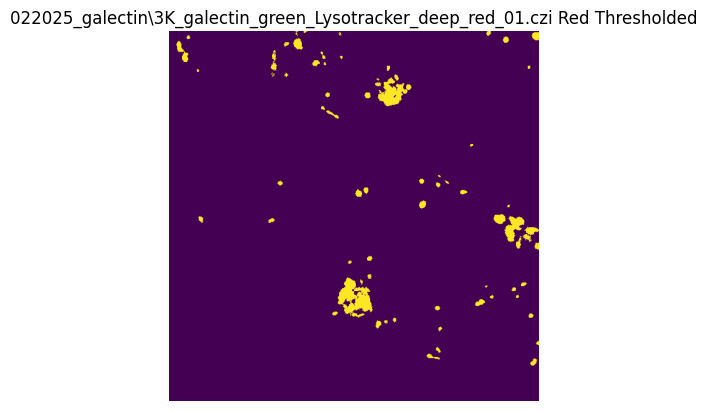

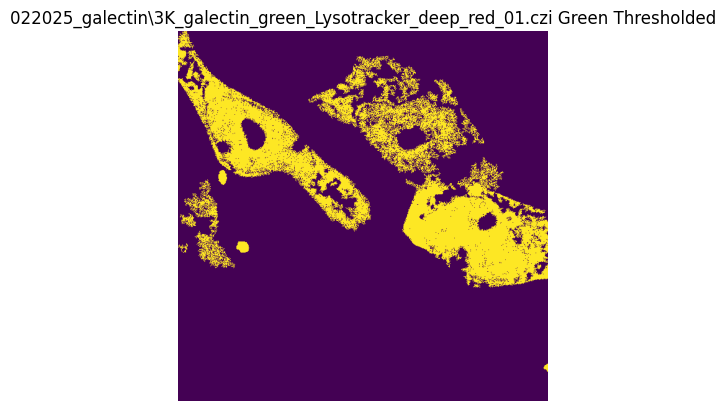

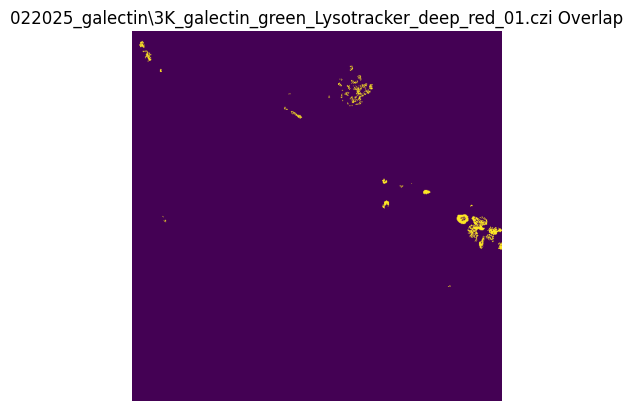

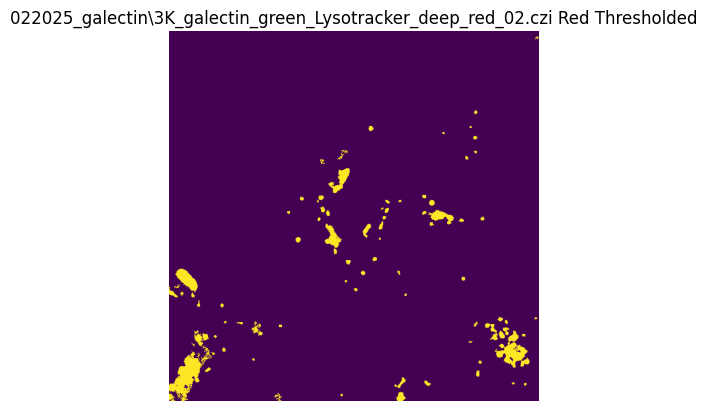

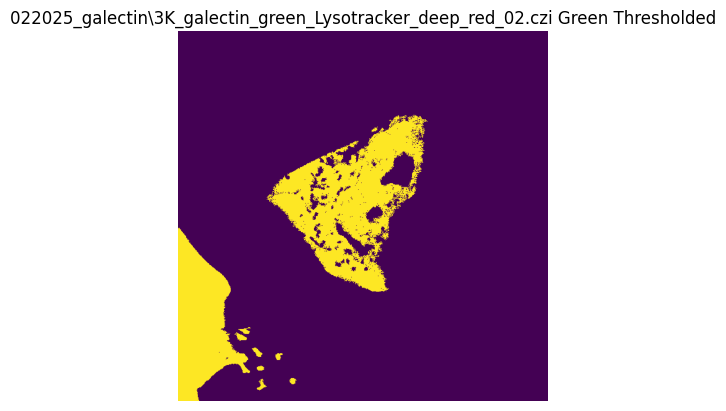

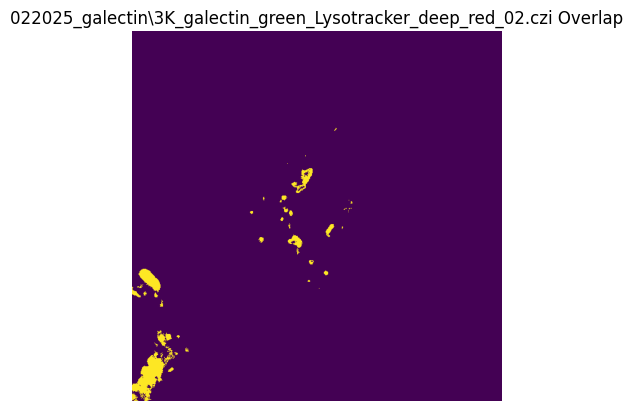

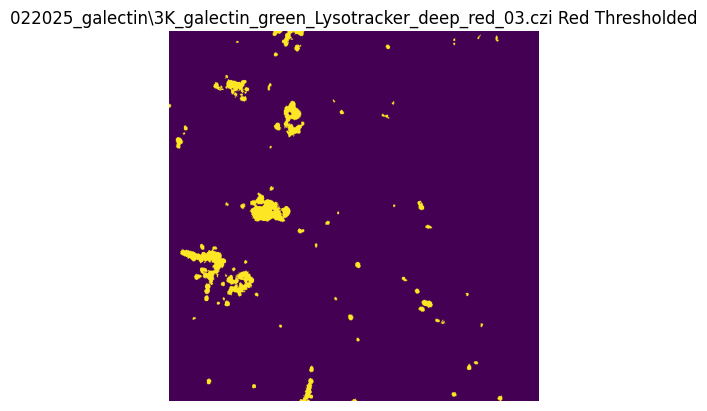

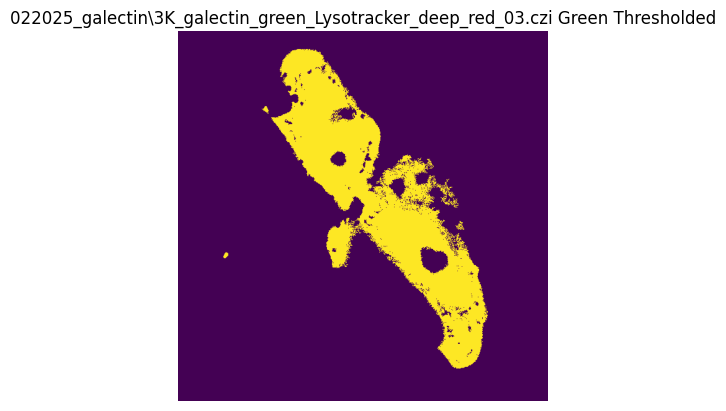

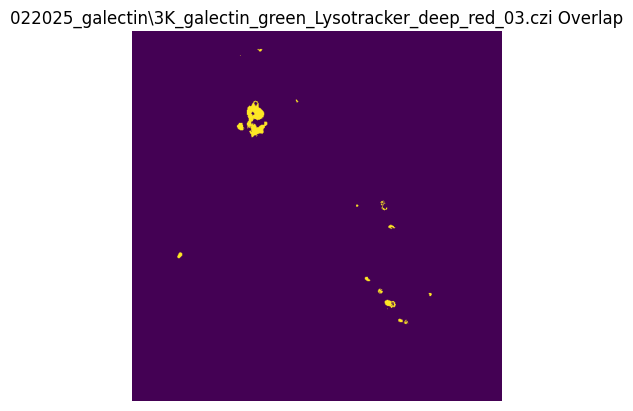

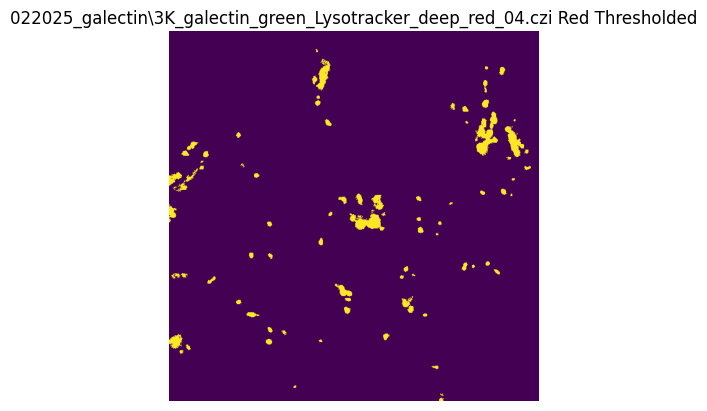

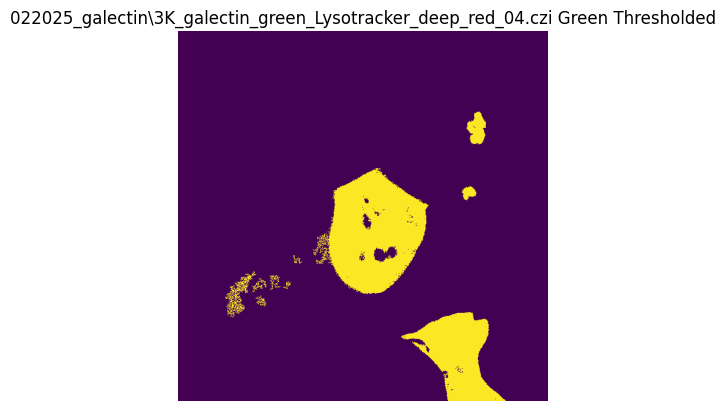

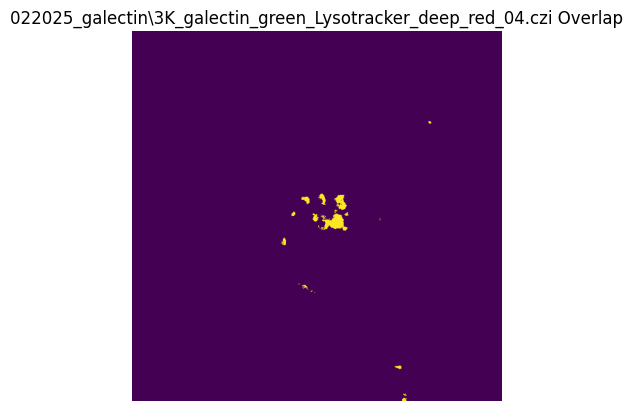

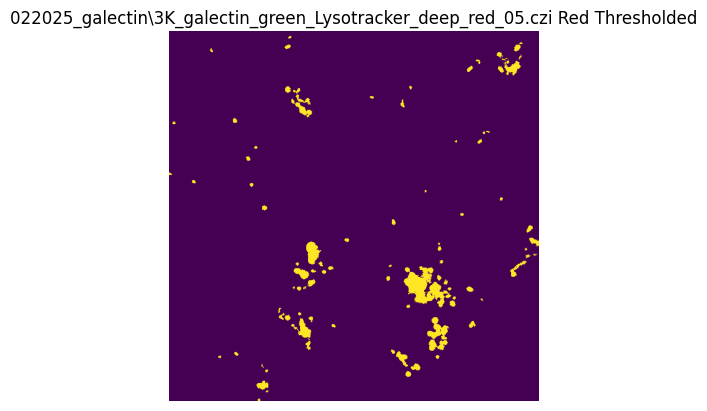

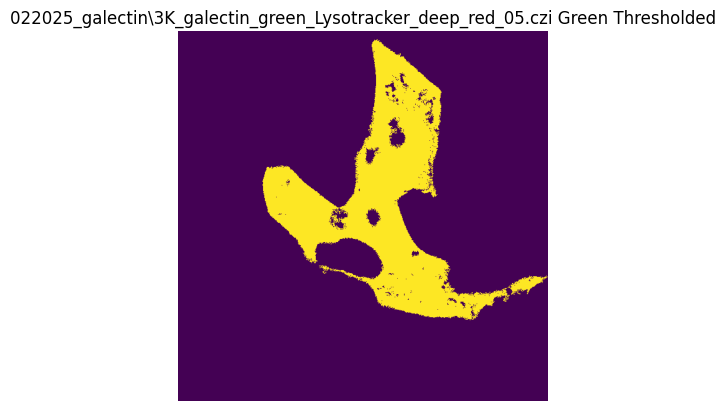

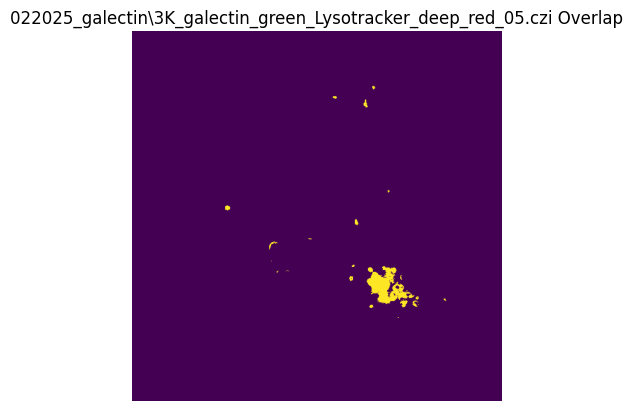

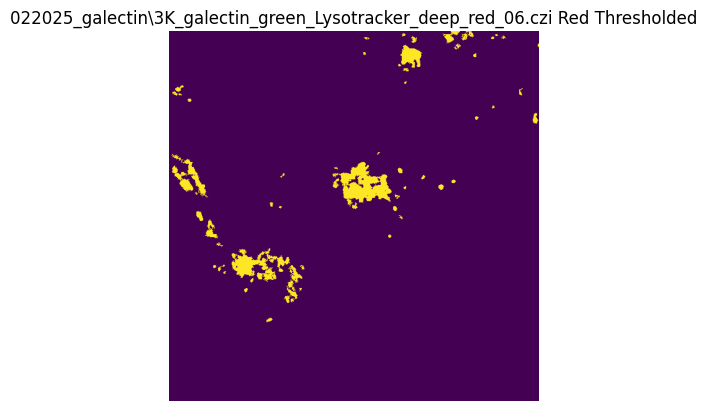

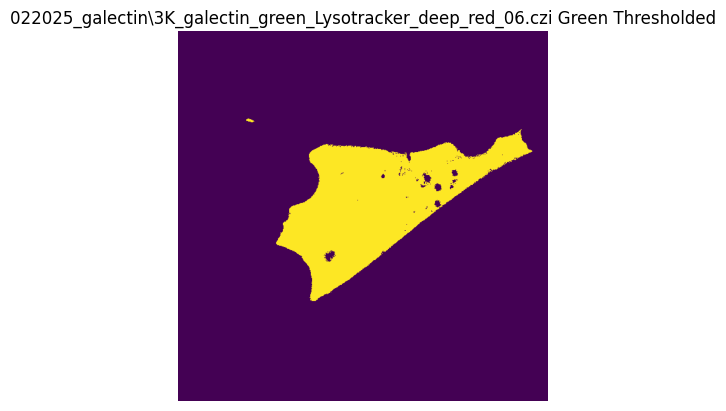

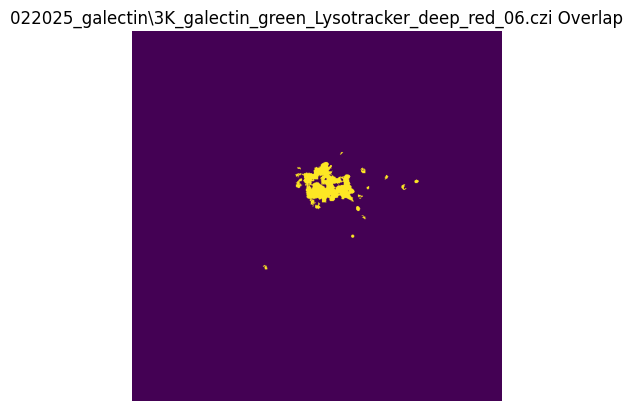

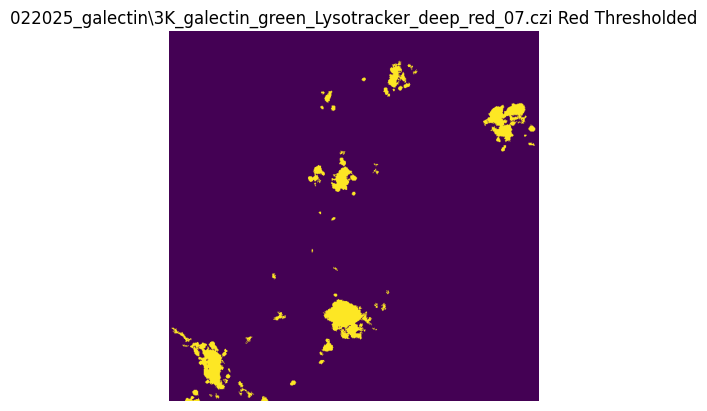

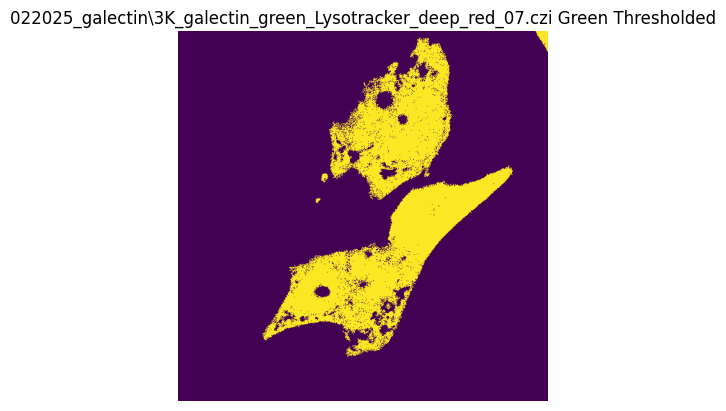

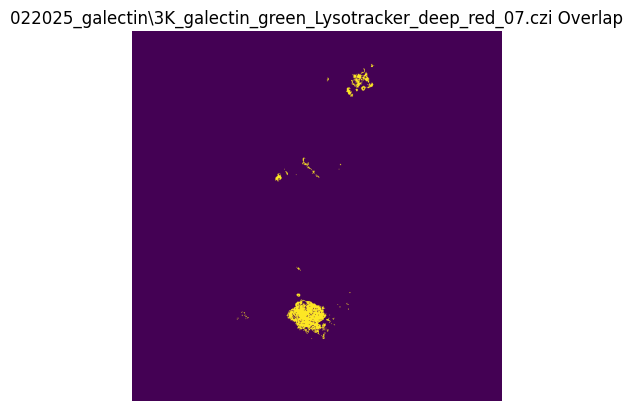

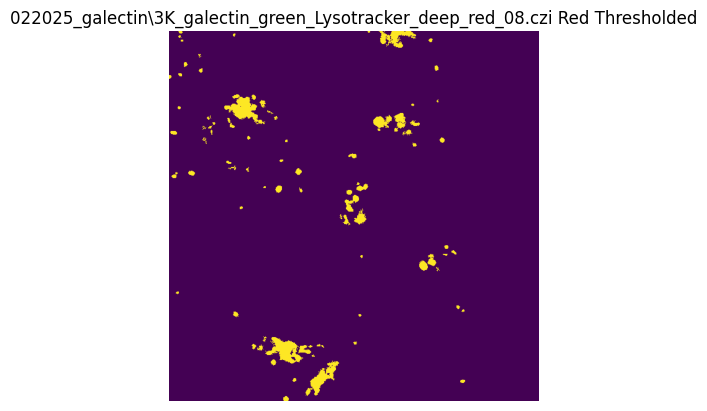

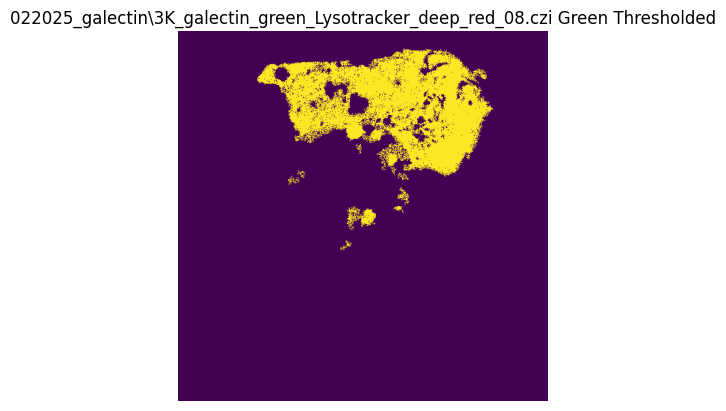

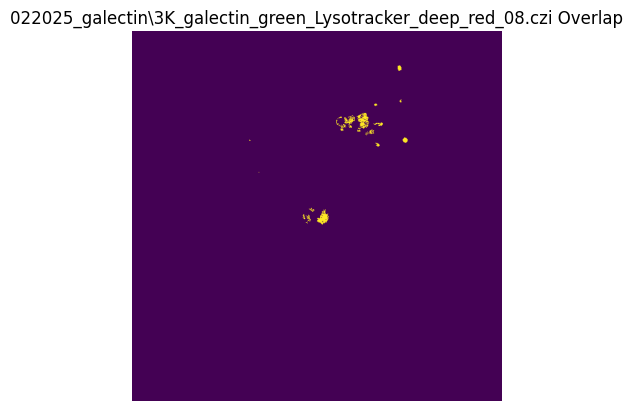

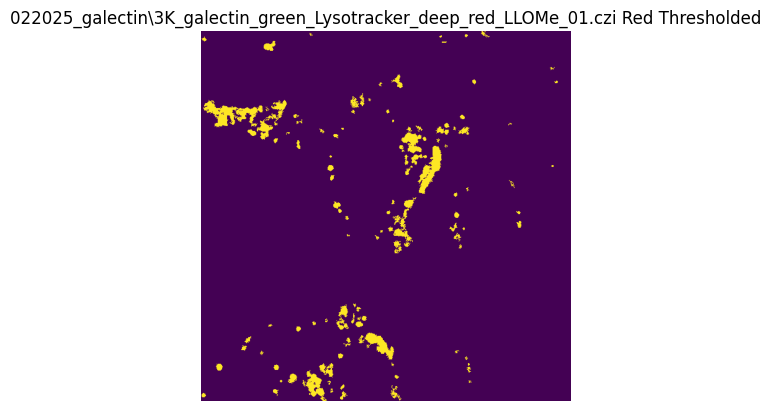

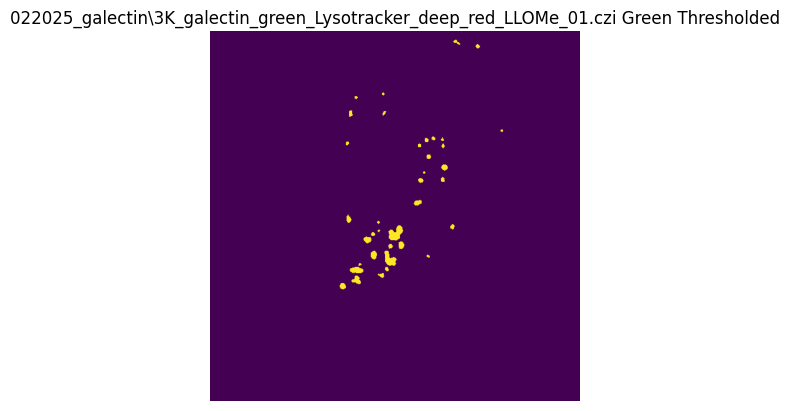

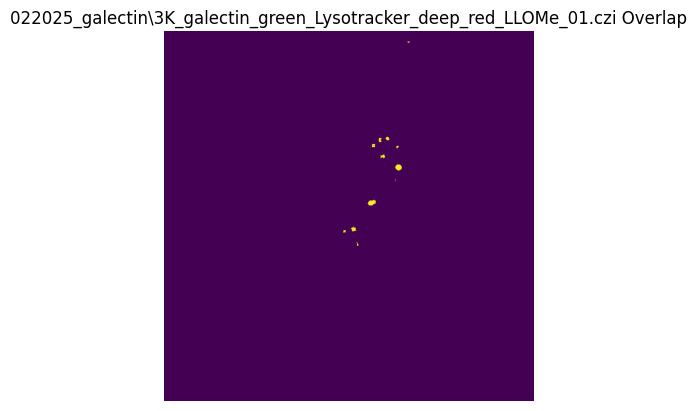

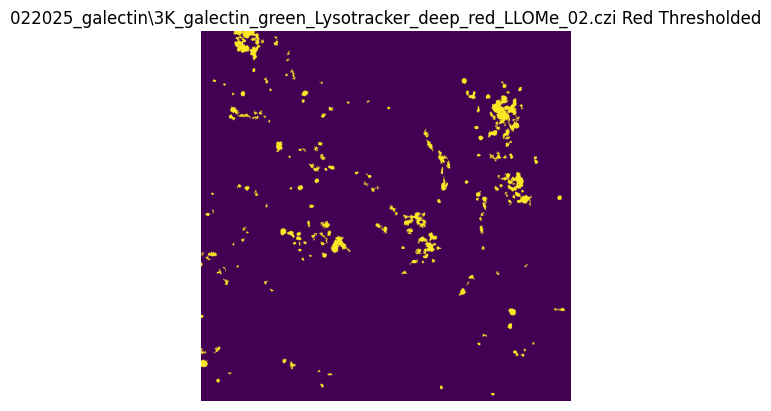

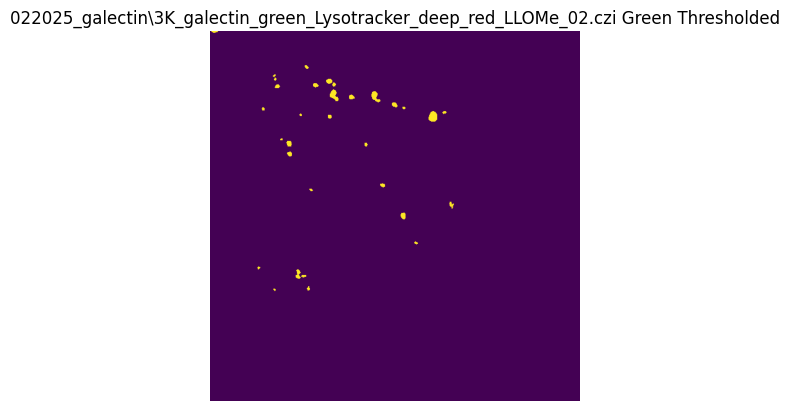

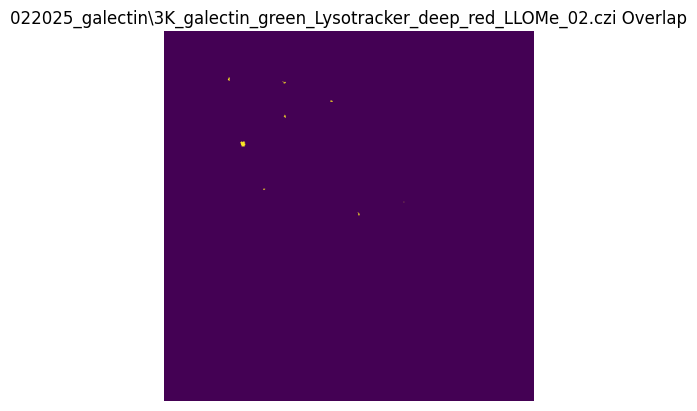

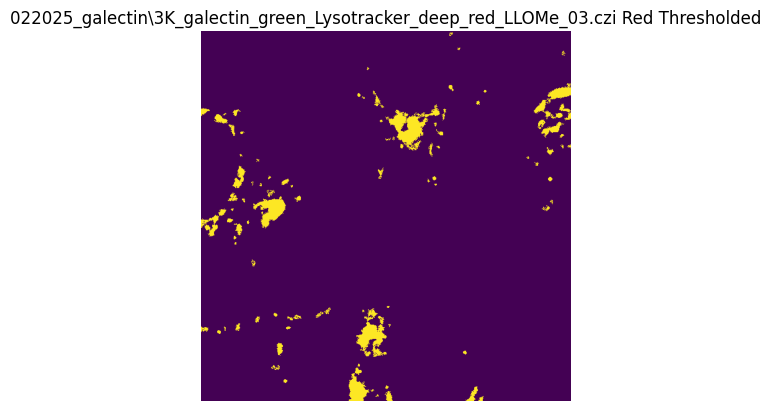

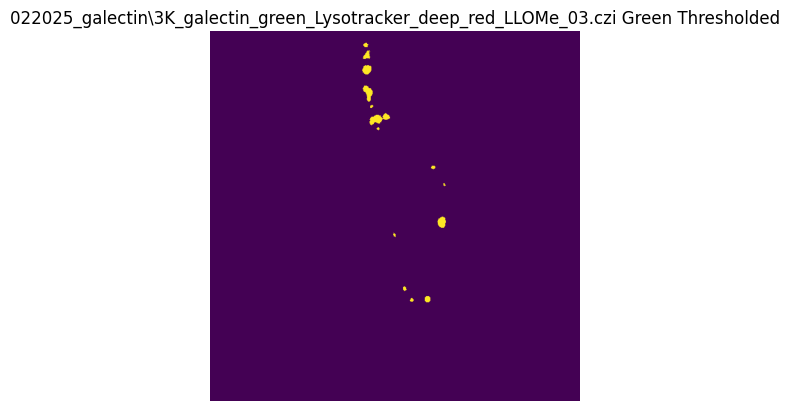

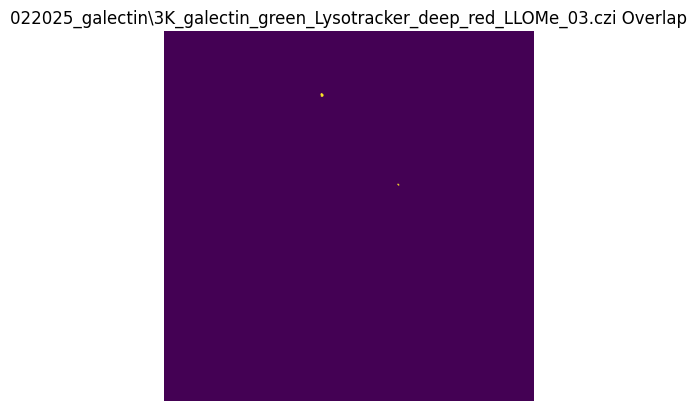

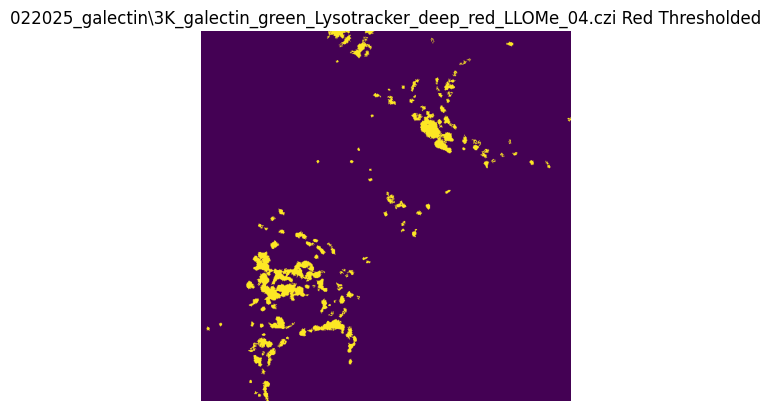

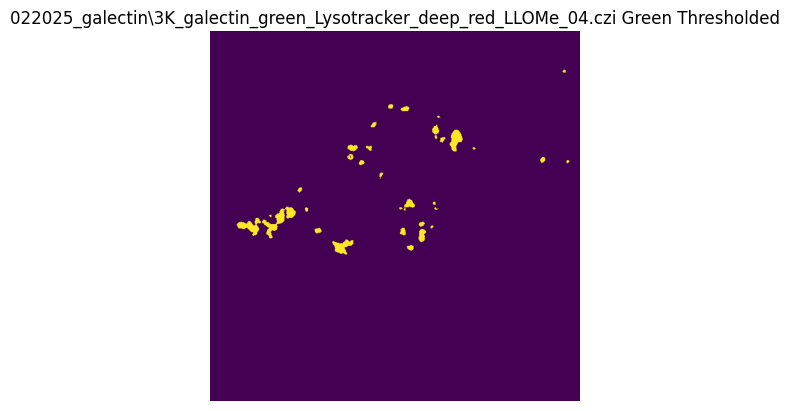

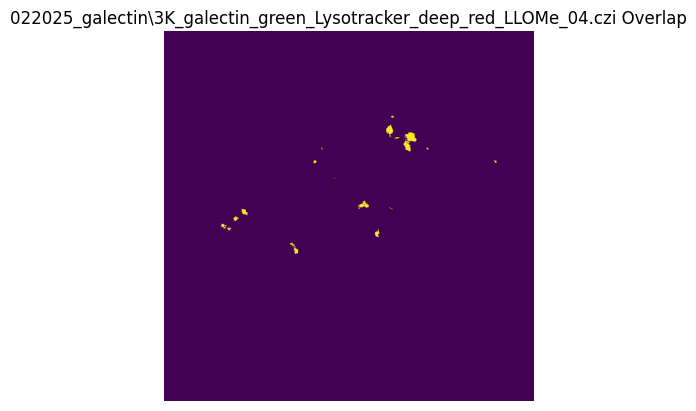

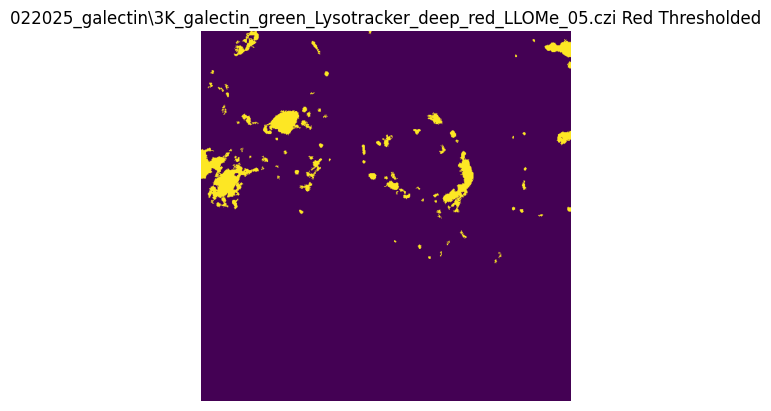

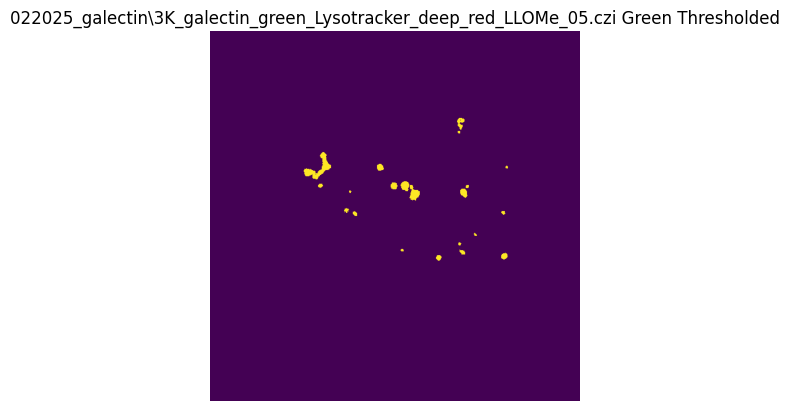

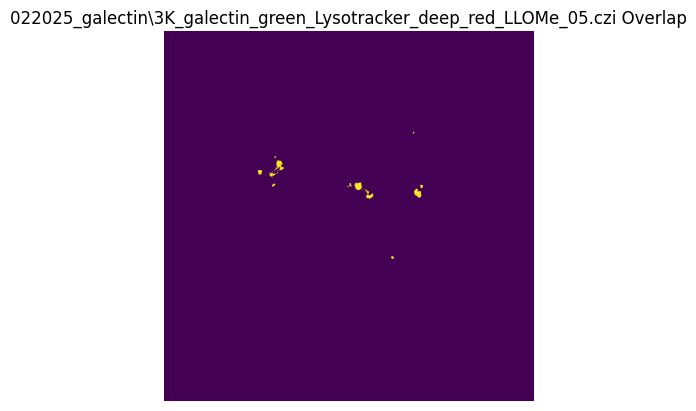

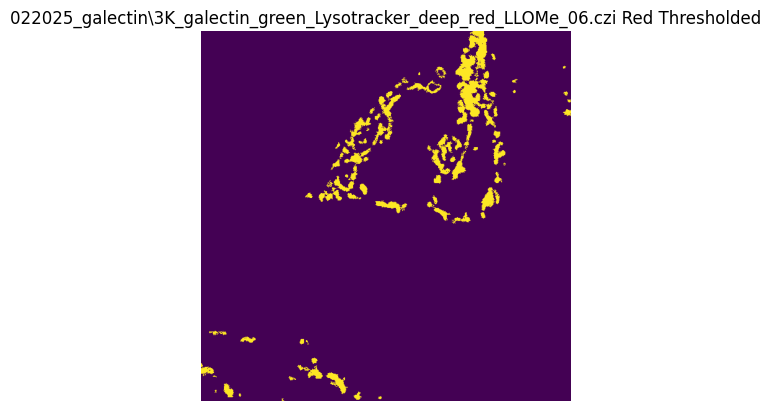

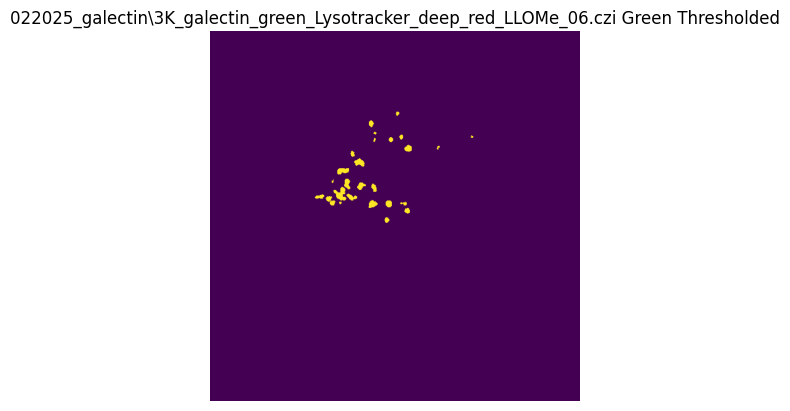

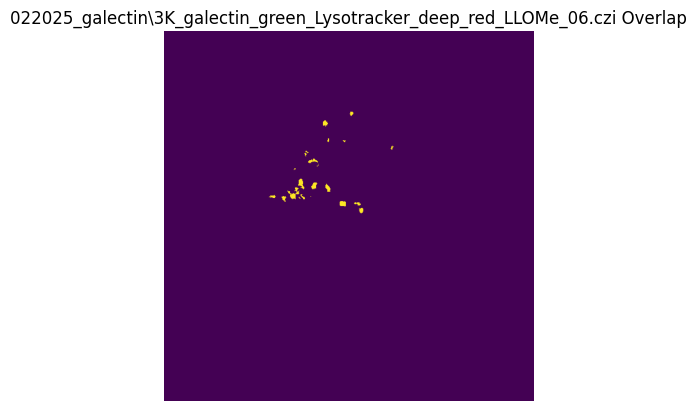

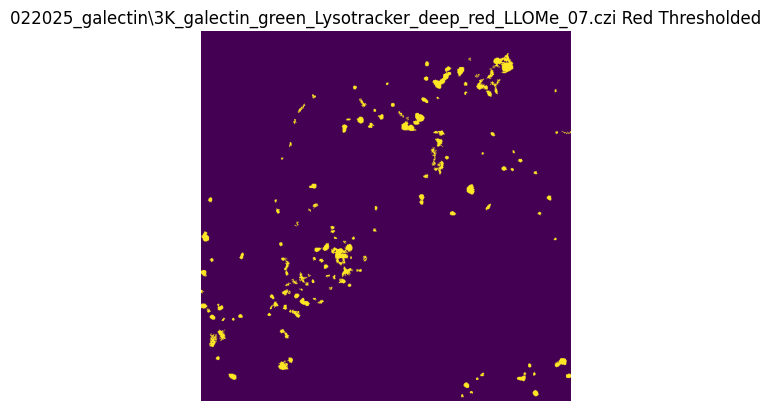

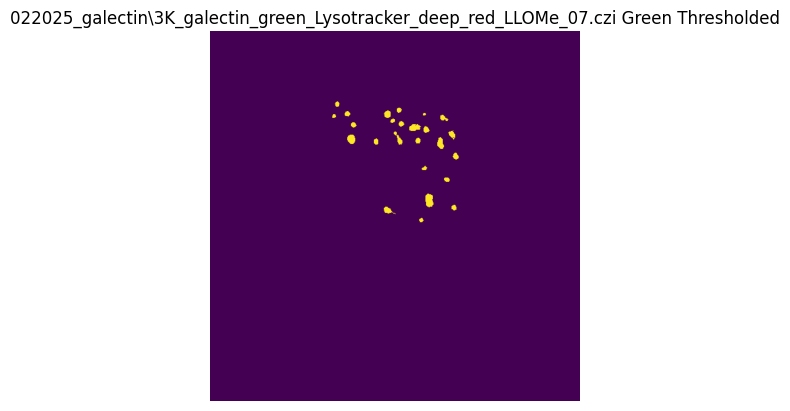

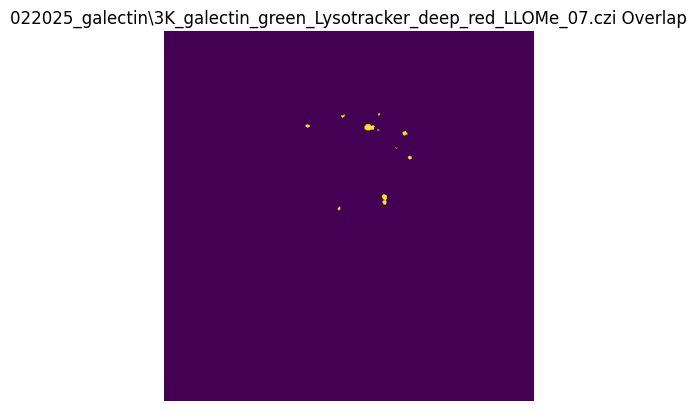

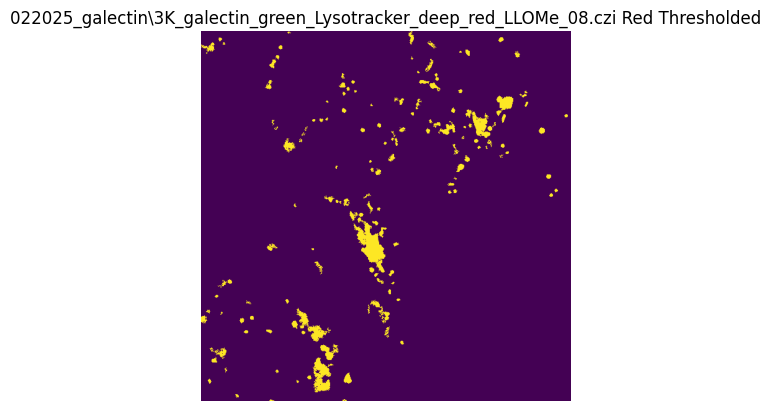

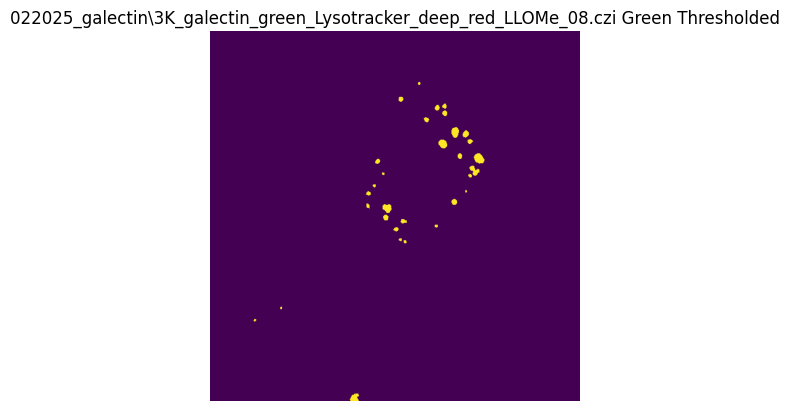

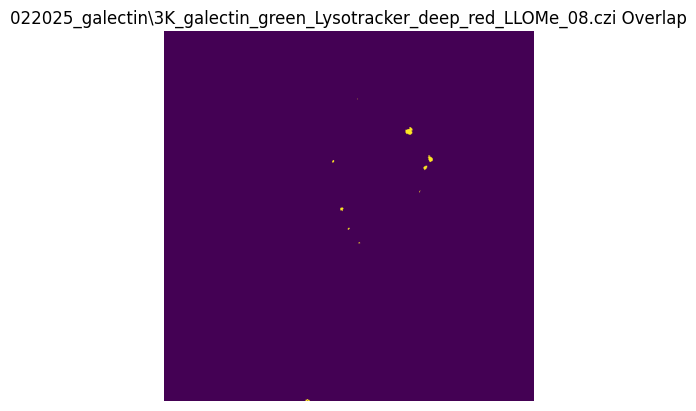

In [18]:
def main(image_folder):
    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()

    df_summary = []
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 

        red, green = extract_channels(image_squeezed)

        df_cell_summary = analysis(red, green, path)
        df_summary.append(df_cell_summary)

    df_summary_combined_df = pd.concat(df_summary, ignore_index=True)
    output_df_summary_path = os.path.join(output_dir, '022025_galectin.xlsx')
    df_summary_combined_df.to_excel(output_df_summary_path, index=False)



if __name__ == "__main__":
    image_folder = '022025_galectin'
    main(image_folder)
